In [16]:
# Force clean restart - remove all cached modules
import sys
import importlib

# Remove slim_tsf and aeon from cache if they exist
for mod in list(sys.modules.keys()):
    if 'slim_tsf' in mod or 'aeon' in mod:
        del sys.modules[mod]

# Add workspace to path
sys.path.insert(0, '/Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction')

# Now do fresh imports
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from scipy.fft import rfft
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt

# Fresh imports from aeon and slim_tsf
from aeon.utils.validation import check_n_jobs
from aeon.utils.numba.stats import row_mean, row_std, row_slope

# Fresh import of SlimTimeSeriesForestClassifier
from slim_tsf.func._slim_TSF import SlimTimeSeriesForestClassifier



✓ All imports reloaded successfully!


In [17]:
data_root = '/Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/data/raw/'

In [18]:
class TimeSeriesDataset:
    def __init__(self, data_dir, labels_file, filename_col='filename', label_col='label', feature_cols=None):
        """
        Args:
            data_dir (str): Path to directory with CSV files.
            labels_file (str): Path to master CSV file.
            filename_col (str): Column name for filenames in master CSV.
            label_col (str): Column name for labels in master CSV.
            feature_cols (list or str): List of columns to load (e.g. ['acc_x', 'acc_y']).
                                        If None, loads all columns.
        """
        self.data_dir = data_dir
        
        # 1. Normalize feature_cols to always be a list
        # This handles cases where user passes "sensor_val" (str) or ["sensor_val"] (list)
        if isinstance(feature_cols, str):
            self.feature_cols = [feature_cols]
        else:
            self.feature_cols = feature_cols
            
        self.metadata = pd.read_csv(labels_file)
        
        # Verify files exist to avoid errors later
        self.metadata['full_path'] = self.metadata[filename_col].apply(
            lambda x: os.path.join(data_dir, str(x) if str(x).endswith('.csv') else f"{x}.csv")
        )
        
        # Filter out files that don't exist
        original_count = len(self.metadata)
        self.metadata = self.metadata[self.metadata['full_path'].apply(os.path.exists)].copy()
        
        if len(self.metadata) < original_count:
            print(f"Warning: {original_count - len(self.metadata)} files were missing and excluded.")

        # Initialize Label Encoder
        self.label_encoder = LabelEncoder()
        self.metadata['encoded_label'] = self.label_encoder.fit_transform(self.metadata[label_col])
        self.classes_ = self.label_encoder.classes_

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        """
        Returns: 
            series: Numpy array of shape (Time_Steps, Num_Features)
            label: Integer label
        """
        row = self.metadata.iloc[idx]
        file_path = row['full_path']
        
        try:
            df = pd.read_csv(file_path)
            
            # 2. Logic to Select Columns
            if self.feature_cols is not None:
                # Check if all requested columns exist in this file
                if set(self.feature_cols).issubset(df.columns):
                    series = df[self.feature_cols].values
                else:
                    # Robust Error Handling: Don't guess. If columns are missing, skip/warn.
                    missing = list(set(self.feature_cols) - set(df.columns))
                    print(f"Error: Columns {missing} missing in {file_path}. Skipping.")
                    return np.array([]), -1
            else:
                # If no specific columns requested, take all values
                series = df.values
                
            return series, row['encoded_label']
            
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            return np.array([]), -1

    def get_splits(self, seed=42):
        """
        Loads ALL data into memory and splits it for Scikit-Learn.
        Returns: (X_train, y_train), (X_val, y_val), (X_test, y_test)
        """
        print(f"Loading {len(self)} multivariate time series into memory...")
        X = []
        y = []
        
        # Eagerly load all data
        for idx in range(len(self)):
            series, label = self[idx]
            # Ensure we only add valid data (non-empty arrays)
            if len(series) > 0:
                X.append(series)
                y.append(label)
        
        y = np.array(y)
        
        # Split 1: 70% Train, 30% Temp
        X_train, X_temp, y_train, y_temp = train_test_split(
            X, y, test_size=0.3, stratify=y, random_state=seed
        )
        
        # Split 2: Divide Temp into Val (10%) and Test (20%)
        X_test, X_val, y_test, y_val = train_test_split(
            X_temp, y_temp, test_size=1/3, stratify=y_temp, random_state=seed
        )
        
        print(f"Data Split Complete: Train={len(X_train)}, Val={len(X_val)}, Test={len(X_test)}")
        
        # Optional: Print shape of first item to verify dimensions
        if len(X_train) > 0:
            print(f"Sample shape (Time, Features): {X_train[0].shape}")
        
        return (X_train, y_train), (X_val, y_val), (X_test, y_test)




In [23]:
dataset = TimeSeriesDataset(
    data_dir=data_root+'/data',
    labels_file=data_root+'/SEP_class_labels.csv',
    filename_col='File',
    label_col='Label',
    feature_cols=['p3_flux_ic', 'p5_flux_ic','p7_flux_ic']  # Example of multiple columns
)
print(f"Classes detected: {dataset.classes_}")

# 2. Get the splits for your Scikit-Learn loop
(X_train, y_train), (X_val, y_val), (X_test, y_test) = dataset.get_splits()

# ... Continue with your existing GridSearch loop ...
# grid_search.fit(X_train, y_train)

Classes detected: [0 1]
Loading 2892 multivariate time series into memory...
Data Split Complete: Train=2024, Val=290, Test=578
Sample shape (Time, Features): (961, 3)


In [24]:
def convert_to_slim_format(X_list, y_list, fixed_length=360):
    """
    Converts list of (Time, Channels) arrays into a (N, Channels, Time) block.
    TRUNCATES or PADS all sequences to 'fixed_length'.
    """
    n_samples = len(X_list)
    n_channels = X_list[0].shape[1]
    
    # Initialize uniform 3D array with the specific fixed length
    X_3d = np.zeros((n_samples, n_channels, fixed_length))
    
    for i, x in enumerate(X_list):
        time_steps = x.shape[0]
        # Transpose (Time, Channels) -> (Channels, Time)
        x_transposed = x.T 
        
        # TRUNCATION LOGIC:
        # If data is longer than fixed_length (360), cut it off.
        if time_steps > fixed_length:
            x_transposed = x_transposed[:, :fixed_length]
            current_len = fixed_length
        else:
            current_len = time_steps
            
        # Fill the array (padding is naturally 0 due to initialization)
        X_3d[i, :, :current_len] = x_transposed[:, :current_len]
        
    return np.array(X_3d), np.array(y_list)

In [25]:
class WindowFFTFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, n_coefficients=10):
        self.n_coefficients = n_coefficients

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        """
        SLIM passes X as (n_cases, 1, window_size).
        We need to return (n_cases, n_features).
        """
        # 1. Remove the channel dimension (it's always 1 here)
        # Shape becomes (n_cases, window_size)
        X_sq = X.squeeze(axis=1)
        
        # 2. Apply FFT along the time axis (axis 1)
        fft_coeffs = rfft(X_sq, axis=1)
        magnitudes = np.abs(fft_coeffs)
        
        # 3. Select Top K Coefficients
        # Limit K to available bins in this specific window
        limit = min(self.n_coefficients, magnitudes.shape[1])
        return magnitudes[:, :limit]

In [30]:
# 1. Load Raw Splits
(X_train_raw, y_train), (X_val_raw, y_val), (X_test_raw, y_test) = dataset.get_splits()

# 2. Convert and Truncate to 360 minutes
# This ensures SLIM only sees the first 360 minutes of every file.
X_train_slim, y_train_slim = convert_to_slim_format(X_train_raw, y_train, fixed_length=360)
X_test_slim, y_test_slim = convert_to_slim_format(X_test_raw, y_test, fixed_length=360)

print(f"SLIM Input Shape: {X_train_slim.shape}") 
# Expected Output: (N, 3, 360)

# 3. Initialize FFT Feature
fft_feature = WindowFFTFeatures(n_coefficients=10)

# 4. Initialize SLIM with Multiple Window Sizes
clf = SlimTimeSeriesForestClassifier(
    n_estimators=100,
    
    # Define the sliding windows you requested.
    # Logic:
    # - 360: Looks at the whole truncated sequence at once (Global FFT)
    # - 180: Slides 50% (0-180, 90-270, 180-360...)
    # - 90:  Slides more frequently
    # - 45:  Captures very local frequency bursts
    windows=[360, 180, 90, 45], 
    
    features=[
        fft_feature
    ],
    sec_trans=True, # Important: Aggregates features across the sliding steps
    n_jobs=-1,
    random_state=42
)

# 5. Train and Evaluate
print("Training SLIM-TSF on first 360 minutes...")
clf.fit(X_train_slim, y_train_slim)



Loading 2892 multivariate time series into memory...
Data Split Complete: Train=2024, Val=290, Test=578
Sample shape (Time, Features): (961, 3)
SLIM Input Shape: (2024, 3, 360)
Training SLIM-TSF on first 360 minutes...
Test Accuracy: 0.8547


Validation Set Shape: (290, 3, 360)

==================== Train Set Evaluation ====================
       Metric  Score
F1 (Weighted) 0.8759
Precision (W) 0.9046
   Recall (W) 0.8572
          TSS 0.4725
          HSS 0.3386

==================== Validation Set Evaluation ====================
       Metric  Score
F1 (Weighted) 0.8936
Precision (W) 0.9255
   Recall (W) 0.8759
          TSS 0.6372
          HSS 0.4380

==================== Test Set Evaluation ====================
       Metric  Score
F1 (Weighted) 0.8740
Precision (W) 0.9039
   Recall (W) 0.8547
          TSS 0.4709
          HSS 0.3346

==================== Feature Importance Analysis ====================
Top 10 Features Cumulative Importance: 37.00%
Top 20 Features Cumulative Importance: 57.00%
Top 30 Features Cumulative Importance: 76.00%
Top 50 Features Cumulative Importance: 96.00%


/var/folders/f7/zbff57wd2h14dcx8bnpxwkk80000gn/T/ipykernel_48751/2213744695.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances, y=feature_labels, palette="viridis", orient='h')


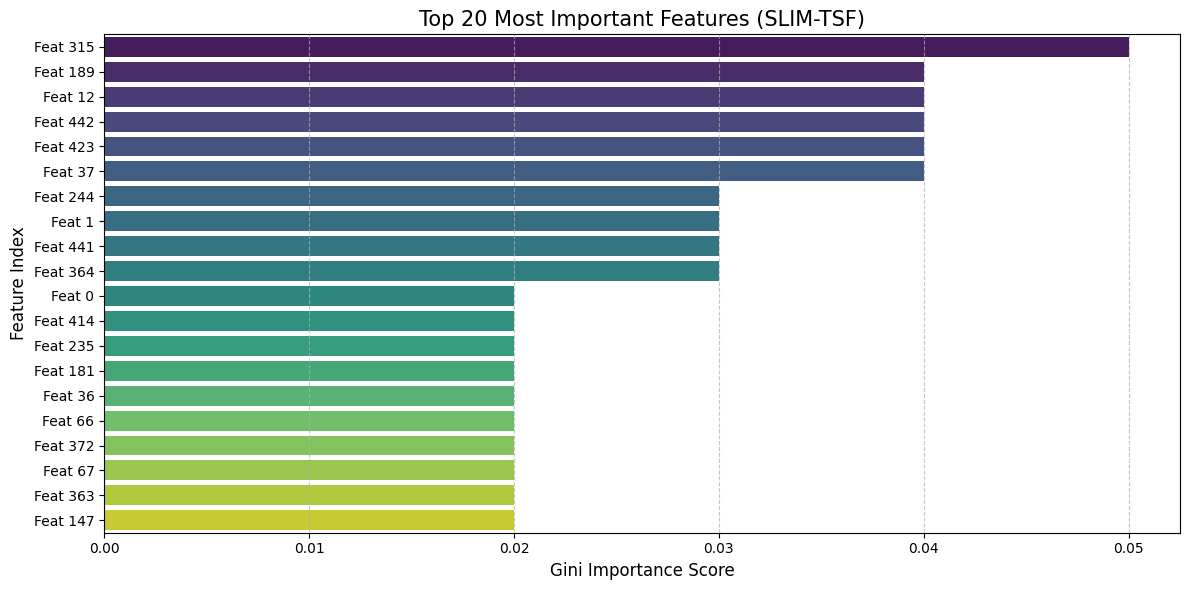

In [31]:
from sklearn.metrics import (precision_score, recall_score, f1_score, 
                             confusion_matrix)
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. METRICS CALCULATION FUNCTIONS
# ==========================================

def calculate_solar_metrics(y_true, y_pred):
    """Calculates TSS and HSS for solar flare prediction."""
    cm = confusion_matrix(y_true, y_pred)
    
    # Handle binary vs multiclass (Treating Class 1 as 'Positive/Flare')
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
    else:
        # One-vs-Rest approach for Class 1 (Positive)
        tp = cm[1, 1]
        fn = cm[1, 0] + cm[1, 2:].sum()
        fp = cm[0, 1] + cm[2:, 1].sum()
        tn = cm.sum() - (tp + fp + fn)

    # TSS (True Skill Statistic)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    tss = sensitivity + specificity - 1
    
    # HSS (Heidke Skill Score)
    numerator = 2 * (tp * tn - fp * fn)
    denominator = ((tp + fn) * (fn + tn) + (tp + fp) * (fp + tn))
    hss = numerator / denominator if denominator != 0 else 0
    
    return tss, hss

def evaluate_model(clf, X, y, dataset_name="Test"):
    """
    Runs evaluation with selected metrics: F1, Precision, Recall, TSS, HSS.
    """
    print(f"\n{'='*20} {dataset_name} Set Evaluation {'='*20}")
    
    # Generate Predictions
    y_pred = clf.predict(X)

    # Standard Metrics (Weighted for class imbalance)
    f1 = f1_score(y, y_pred, average='weighted')
    prec = precision_score(y, y_pred, average='weighted')
    rec = recall_score(y, y_pred, average='weighted')

    # Solar Metrics
    tss, hss = calculate_solar_metrics(y, y_pred)

    # Create Metrics Table
    metrics_df = pd.DataFrame({
        'Metric': ['F1 (Weighted)', 'Precision (W)', 'Recall (W)', 'TSS', 'HSS'],
        'Score': [f1, prec, rec, tss, hss]
    })
    
    print(metrics_df.to_string(index=False, float_format="%.4f"))
    return metrics_df

# ==========================================
# 2. FEATURE ANALYSIS & PLOTTING
# ==========================================

def display_top_features(clf, k_values=[10, 20, 30, 50]):
    """
    Displays cumulative importance of top K features.
    """
    print(f"\n{'='*20} Feature Importance Analysis {'='*20}")
    
    if hasattr(clf, 'clf'):
        rf_model = clf.clf 
        importances = rf_model.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        for k in k_values:
            top_k_indices = indices[:k]
            total_importance = sum(importances[top_k_indices])
            print(f"Top {k:<2} Features Cumulative Importance: {total_importance:.2%}")
    else:
        print("Model does not expose feature importances.")

def plot_top_features(clf, k=20, figsize=(12, 6)):
    """
    Plots a bar chart of the Top K most important features.
    """
    if not hasattr(clf, 'clf'):
        print("Model does not expose feature importances.")
        return

    # Extract importances
    importances = clf.clf.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    # Select Top K
    top_indices = indices[:k]
    top_importances = importances[top_indices]
    
    # Create Labels
    feature_labels = [f"Feat {i}" for i in top_indices]

    # Plot
    plt.figure(figsize=figsize)
    sns.barplot(x=top_importances, y=feature_labels, palette="viridis", orient='h')
    
    plt.title(f"Top {k} Most Important Features (SLIM-TSF)", fontsize=15)
    plt.xlabel("Gini Importance Score", fontsize=12)
    plt.ylabel("Feature Index", fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# ==========================================
# 3. EXECUTION
# ==========================================

# 1. Convert Validation Set to SLIM format (Truncate to 360)
# (Assumes X_val_raw and y_val exist from your dataset.get_splits() call)
X_val_slim, y_val_slim = convert_to_slim_format(X_val_raw, y_val, fixed_length=360)
print(f"Validation Set Shape: {X_val_slim.shape}")

# 2. Evaluate Performance on ALL sets
train_metrics = evaluate_model(clf, X_train_slim, y_train_slim, "Train")
val_metrics   = evaluate_model(clf, X_val_slim,   y_val_slim,   "Validation")
test_metrics  = evaluate_model(clf, X_test_slim,  y_test_slim,  "Test")

# 3. Print Feature Stats
display_top_features(clf, k_values=[10, 20, 30, 50])

# 4. Plot Feature Importances
plot_top_features(clf, k=20)